1. Preprocess
2. Data Loader
3. Model define

# LSTM

* https://github.com/SheezaShabbir/Time-series-Analysis-using-LSTM-RNN-and-GRU/blob/main/Pytorch_LSTMs%2CRNN%2CGRU_for_time_series_data.ipynb
* https://github.com/vincrichard/LSTM-AutoEncoder-Unsupervised-Anomaly-Detection/blob/master/DataChallengeReport_VincentRichard.ipynb
* https://github.com/yakhyo/pytorch-tutorials/blob/main/tutorials/03-intermediate/04-lstm-network/main.py
* https://github.com/yakhyo/pytorch-tutorials/blob/main/tutorials/03-intermediate/05-var-auto-encode/main.py
* https://github.com/vincrichard/LSTM-AutoEncoder-Unsupervised-Anomaly-Detection/blob/master/DataChallengeReport_VincentRichard.ipynb

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

## 1. Preprocessing

In [2]:
df = pd.read_csv('./training_spiral.csv')
feature_list = ['Fx','Fy','Fz','Mx','My']
TIMESTEP = 50
BATCH_SIZE = 32

In [3]:
df.shape

(357823, 20)

In [4]:
df = df.iloc[:50000]

In [5]:
df.shape

(50000, 20)

In [6]:
df.Case.value_counts()

False    50000
Name: Case, dtype: int64

In [7]:
def to_sequence(data, timesteps=1):
    n_features=data.shape[2]
    x = []
    y = []
    for i in range(len(data)-timesteps):
        # takes a window of data of specified timesteps
        
        _x = data[i:(i+timesteps)]
        _x = _x.reshape(timesteps, n_features)
#         print(_x.shape)
        _y = data[i+timesteps]
        _y = _y.reshape(n_features)
#         print(_y.shape)
        x.append(_x)
        y.append(_y)

        
    return np.array(x), np.array(y)

In [8]:
df_total = df[feature_list]
window = 40
df_total = df_total.rolling(window).mean()
# due to the moving average we the first (window-1) rows become NaN so we remove them
df_total = df_total.loc[window-1:]
print(df_total.shape)


(49961, 5)


In [9]:
train_size = len(df_total)*0.9
df_train, df_valid = df_total.loc[:train_size],df_total.loc[train_size:] 
print(f"Train size: {df_train.shape} | Valid size: {df_valid.shape}")

Train size: (44926, 5) | Valid size: (5035, 5)


In [10]:
train = np.expand_dims(df_train, axis=1)
valid = np.expand_dims(df_valid, axis=1)

x_train, y_train = to_sequence(train, timesteps=TIMESTEP)
x_valid, y_valid = to_sequence(valid, timesteps=TIMESTEP)

print(f"X_train: {x_train.shape} | y_train: {y_train.shape}")
print(f"X_valid: {x_valid.shape} | y_valid: {y_valid.shape}")

X_train: (44876, 50, 5) | y_train: (44876, 5)
X_valid: (4985, 50, 5) | y_valid: (4985, 5)


## 2. Data Loader

In [11]:
x_train_torch, y_train_torch = torch.Tensor(x_train), torch.Tensor(y_train)
x_valid_torch, y_valid_torch = torch.Tensor(x_valid), torch.Tensor(y_valid)

train_dataset = TensorDataset(x_train_torch, y_train_torch)
valid_dataset = TensorDataset(x_valid_torch, y_valid_torch)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
x_train, y_train = next(iter(train_loader))
print(f"X Train batch shape: {x_train.size()}")
print(f"Y Train batch shape: {y_train.size()}")

X Train batch shape: torch.Size([32, 50, 5])
Y Train batch shape: torch.Size([32, 5])


## 3. Model Building

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using:", device)

Using: cpu


## 3.1. LSTM 
LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

1. `input, (h_0, c_0)`
    * input: `(N, L, Hin)`
    * h_0: tensor of shape `(num_layers, N,hidden_size)`, defaults to zeros 
    * c_0: tensor of shape `(num_layers, N, Hcell)`
2. `output, (h_n, c_n)`
    * output: `(N,L,hidden_size)`
    * h_n: containing final hidden state for each element in the sequence: `(num_layers, N, hidden_size)`
    * c_0:  `(num_layers, N, Hcell)`

In [15]:
class LSTMModel(nn.Module):
    """
    Attributes:
        input_size: number of expected features in X
        hidden_size: how many LSTM cells are there in each hidden layer
        num_layers: how many stacked LSTMs we want to use
        output_dim: LSTM output shape
    """
    def __init__(self, input_size, hidden_size, num_layers, output_dim, print_info):
        super(LSTMModel, self).__init__()
        self.print_info = print_info
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
                
        # LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully Connected
        # Output_dim == number of features (1 pred per feature)
        self.fc = nn.Linear(hidden_size, output_dim)
        
    def _init_hidden(self, X):
        batch_size = X.size(0)
        device = X.device
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        
        return h0, c0
        
    def forward(self, X):
        """
        input (X): should be of shape (batch_size, seq_length, hidden_size)
        """
        # initialize hidden and cell states
        h0, c0 = self._init_hidden(X)
        # call lstm
        out, (hn, cn) = self.lstm(X, (h0.detach(), c0.detach()))
        # for plotting
        init_out = out
        # out: batch_size, seq_len, hidden_size
        # out(N, 28, 128)
        out = out[:,-1,:]
        out_reshaped = out
        # we want last timestep: out (N, 128)
        out = self.fc(out)
        # batch_size, output_dim
        
        if self.print_info:
            print('X shape:', X.shape)
            print(f"h0 shape: {h0.shape}, c0 shape: {c0.shape}")
            print('init_out shape:', init_out.shape)
            print('output_reshaped', out_reshaped.shape)
            print('out shape:', out.shape)
            
        return out
        

In [16]:
#  input_size: number of expected features in X
#  hidden_size: how many LSTM cells are there in each hidden layer
#  num_layers: how many stacked LSTMs we want to use

input_size = 5
hidden_size = 32
num_layers = 1
output_dim = 5

sequence_dim = TIMESTEP

# instatiate model
model = LSTMModel(input_size, hidden_size, num_layers, output_dim, print_info=False)
# moving model to the GPU 
model = model.to(device)
print(model)

LSTMModel(
  (lstm): LSTM(5, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)


In [17]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# loss
criterion = torch.nn.MSELoss()

## 4. Training

In [18]:
print(f"Length of Train Loader {len(train_loader)} batches of {BATCH_SIZE}")

Length of Train Loader 1403 batches of 32


In [19]:
def train_step(model, train_loader, criterion, optimizer, device):
    """
    Function responsible for performing learning for one epoch.
    Attributes:
        model: model to be trained
        train_loader: data loader for the training set
        criterion: loss function
        optimizer: optimizer used for updating the loss
    Returns:
        train_loss: average training loss from 1 epoch 
    """
    # training mode
    model.train()
    
    train_loss = 0
    # we track the batch index 
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        
        # moving data to the GPU 
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # prediction
        yhat = model(x_batch)
        
        # calculate loss
        loss = criterion(y_batch, yhat)
        train_loss += loss.item()
        
        # zero gradient
        optimizer.zero_grad()
        
        # backprop gradient
        loss.backward()
        
        # loss step
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('\r', 'Training [{}/{} ({:.0f}%)] \tLoss: {:.6f})]'.format(
                batch_idx + 1, len(train_loader),
                (batch_idx + 1) * 100 / len(train_loader),
                loss.item()), sep='', end='', flush=True)
        
    train_loss = train_loss/ len(train_loader)
    return train_loss

In [20]:
def validation_step(model, valid_loader, criterion, device):
    """
    Function responsible for performing evaluation of trained model on the test set for one epoch.
    Attributes:
        model: trained model to be used
        valid_loader: data loader for the validation set
        criterion: loss function
    Returns:
        valid_loss: average validation loss from 1 epoch 
    """
    # no training, equivalent to model.learn(False)
    model.eval()
    
    # set test loss
    valid_loss = 0
    # turn inference
    with torch.inference_mode():
        for batch_idx, (x_batch, y_batch) in enumerate(valid_loader):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            yhat = model(x_batch)

            loss = criterion(y_batch, yhat)
            valid_loss += loss.item()
        
        print('\r', 'Validation [{}/{} ({:.0f}%)] \tLoss: {:.6f})]'.format(
            batch_idx + 1, len(valid_loader),
            (batch_idx + 1) * 100 / len(valid_loader),
            loss.item()), sep='', end='', flush=True)
        
        valid_loss = valid_loss/ len(valid_loader)
        return valid_loss

In [21]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs, device):
    """
    Function responsible for performing learning for multiple epochs
    Attributes:
        model: model to be trained
        train_loader: data loader for the training set
        criterion: loss function
        optimizer: optimizer used for updating the loss
    Returns:
        results: dictionary of results
    """
    # dictionary of results
    results = {"train_loss": [],
              "valid_loss": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model, train_loader, criterion, optimizer, device)
        print('====> Epoch: {} Training Average loss: {:.6f}'.format(epoch, train_loss))
        
        valid_loss = validation_step(model, valid_loader, criterion, device)
        print('====> Validation Average loss: {:.6f}'.format(valid_loss))
#         print(f"Epoch: {epoch} | Train loss: {train_loss} | Test loss: {test_loss}")
        
        # update results dicts
        results['train_loss'].append(train_loss)
        results['valid_loss'].append(valid_loss)
        
    return results

In [29]:
def plot_loss_curves(results):
    loss = results['train_loss']
    valid_loss = results['valid_loss']
    
    epochs = range(len(results['train_loss']))
    
    plt.figure()
    plt.title('Training Curve')
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, valid_loss,label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [23]:
results_history = train(model, train_loader, valid_loader, optimizer, criterion, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

Training [1401/1403 (100%)] 	Loss: 0.561454)]====> Epoch: 0 Training Average loss: 1.963846
Validation [156/156 (100%)] 	Loss: 0.574791)]====> Validation Average loss: 0.522705
Training [1401/1403 (100%)] 	Loss: 0.103708)]====> Epoch: 1 Training Average loss: 0.307952
Validation [156/156 (100%)] 	Loss: 0.121775)]====> Validation Average loss: 0.116769
Training [1401/1403 (100%)] 	Loss: 0.015361)]====> Epoch: 2 Training Average loss: 0.069371
Validation [156/156 (100%)] 	Loss: 0.024815)]====> Validation Average loss: 0.036265
Training [1401/1403 (100%)] 	Loss: 0.007218)]====> Epoch: 3 Training Average loss: 0.029764
Validation [156/156 (100%)] 	Loss: 0.007246)]====> Validation Average loss: 0.018792
Training [1401/1403 (100%)] 	Loss: 0.003302)]====> Epoch: 4 Training Average loss: 0.016147
Validation [156/156 (100%)] 	Loss: 0.003274)]====> Validation Average loss: 0.010105
Training [1401/1403 (100%)] 	Loss: 0.001341)]====> Epoch: 5 Training Average loss: 0.009054
Validation [156/156 (10

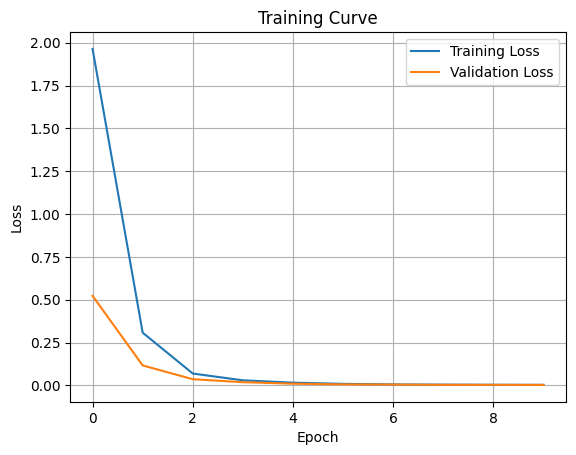

In [30]:
plot_loss_curves(results_history)